# Download data

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import gdown
import os

# Download the file from Google Drive
file_id = '1YFb-yXPKhRiixTk1u6Jv_prDGAw0AslH'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'daunkentang.zip'
gdown.download(url, output, quiet=False)
# https://drive.google.com/file/d/1YFb-yXPKhRiixTk1u6Jv_prDGAw0AslH/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1YFb-yXPKhRiixTk1u6Jv_prDGAw0AslH
From (redirected): https://drive.google.com/uc?id=1YFb-yXPKhRiixTk1u6Jv_prDGAw0AslH&confirm=t&uuid=1dc3c10d-3581-43dd-b430-e852e8a941d8
To: /content/daunkentang.zip
100%|██████████| 29.2M/29.2M [00:00<00:00, 37.8MB/s]


'daunkentang.zip'

In [ ]:
import zipfile

# Nama file ZIP yang akan diekstrak
zip_file = 'daunkentang.zip'

# Direktori tempat Anda ingin mengekstrak file
extract_dir = '/content'

# Membuat direktori jika belum ada
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Ekstraksi file ZIP
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Ekstraksi selesai.")

Ekstraksi selesai.


#Library

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_tuner
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization,InputLayer
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

#Baca Data

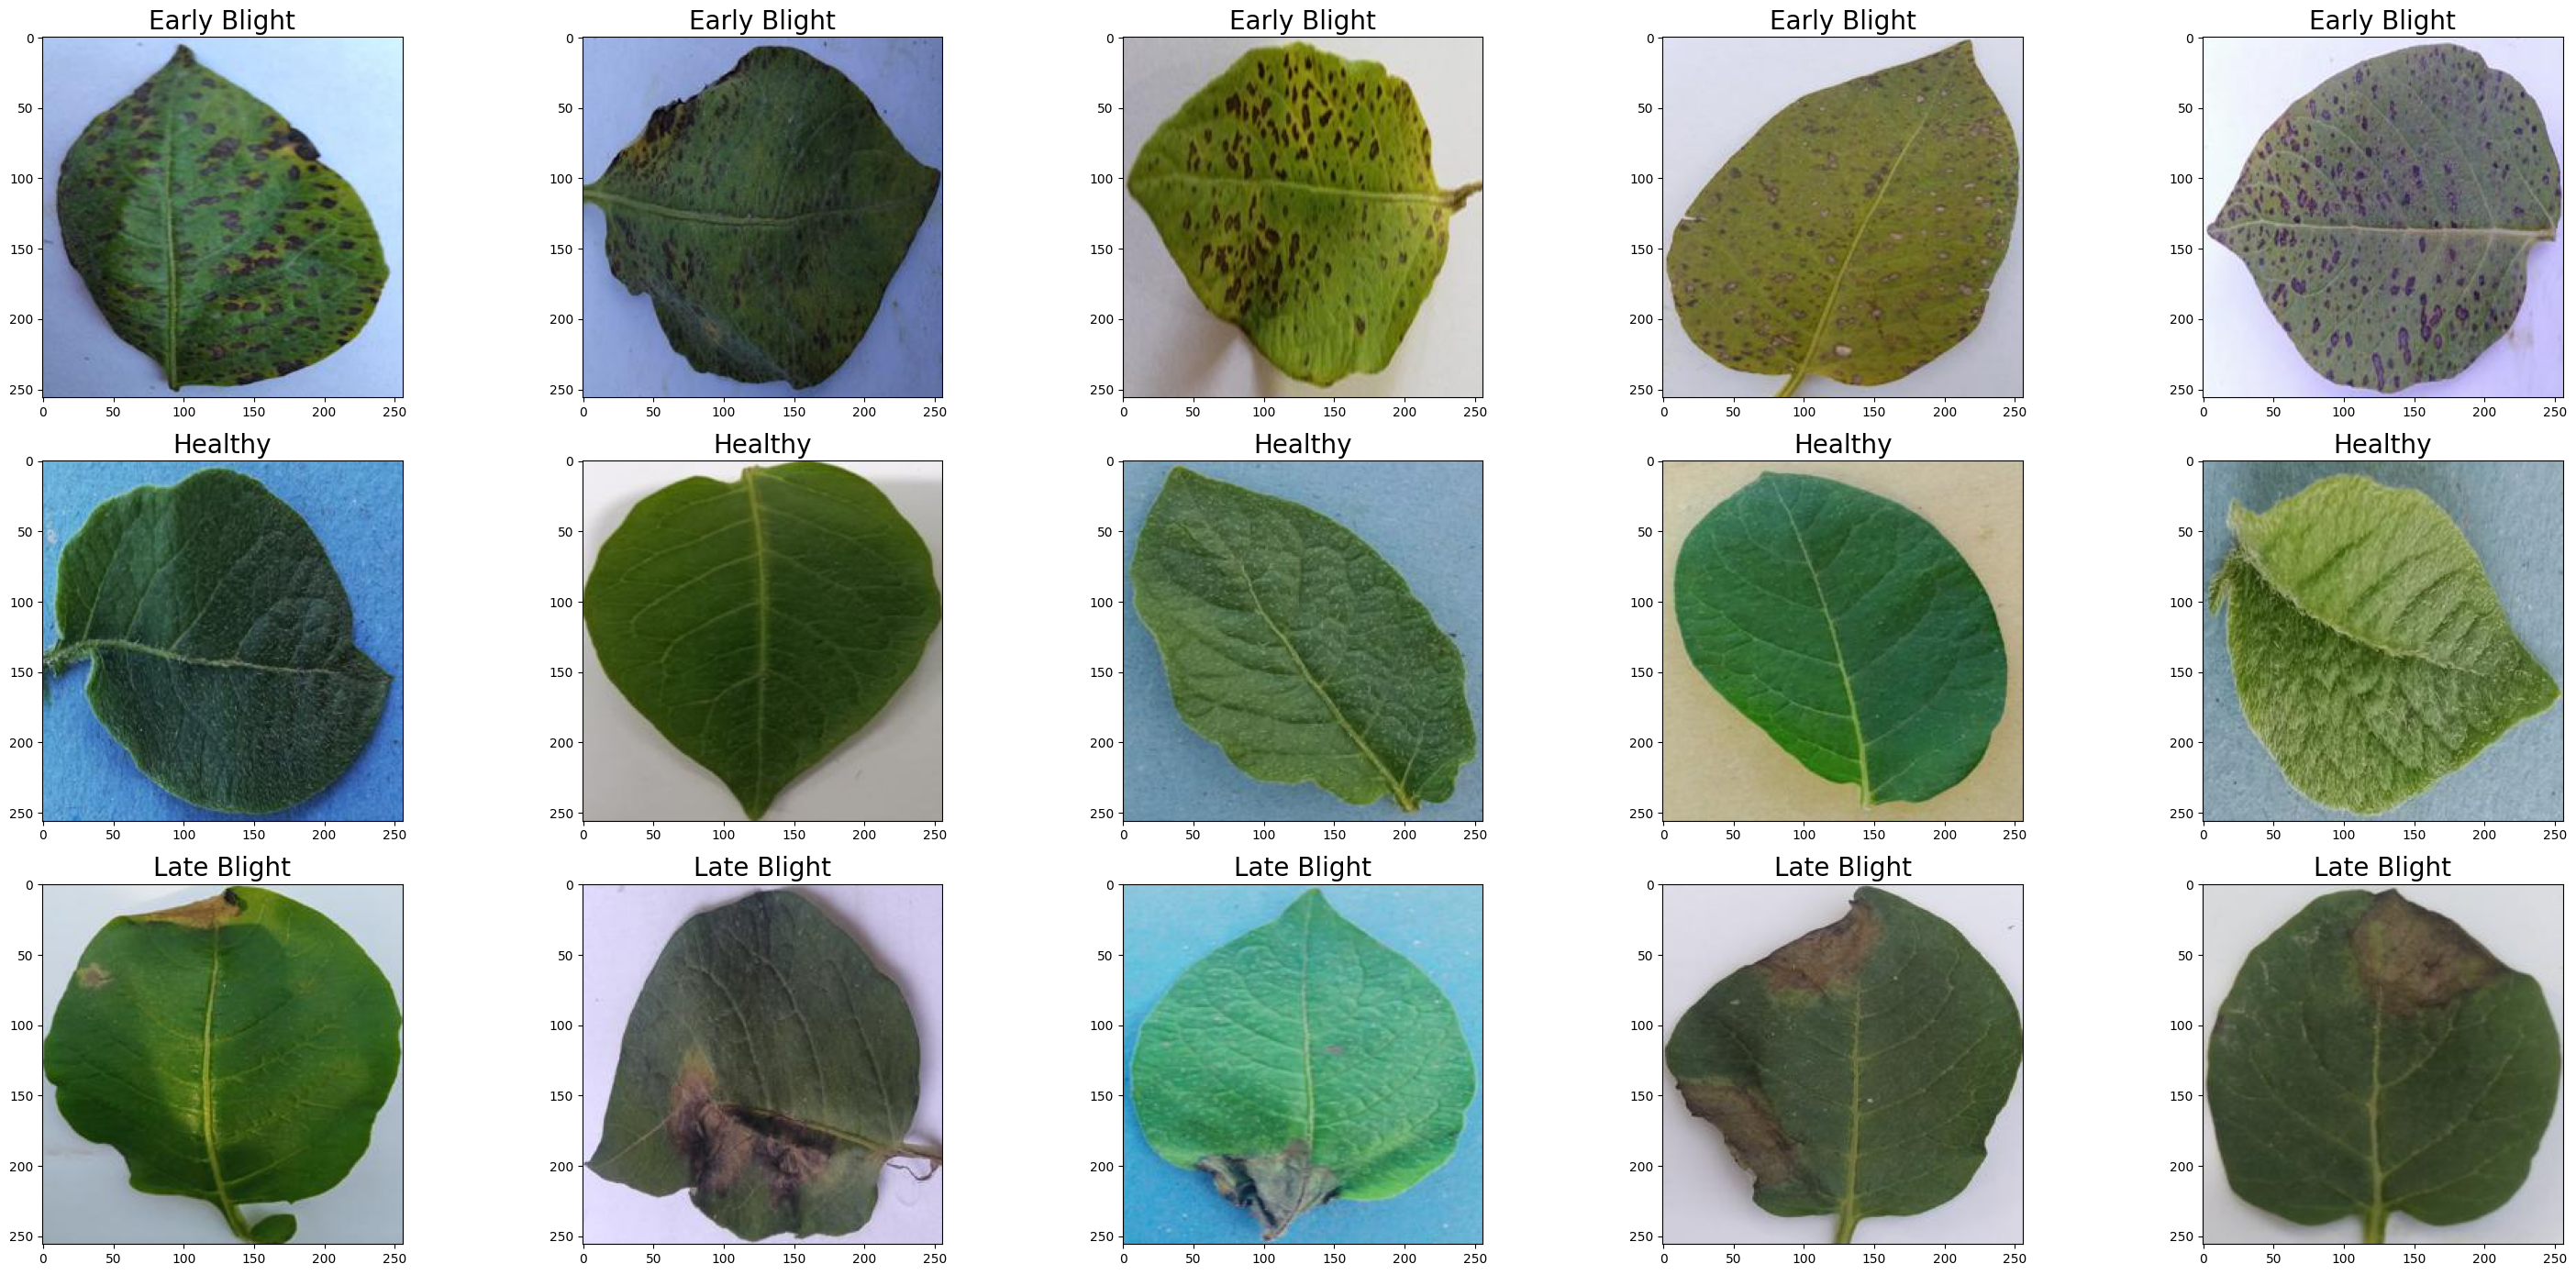

In [ ]:
Early_Blight_path = '/content/Daun_kentang/Training/Early_Blight'
Healthy_path = '/content/Daun_kentang/Training/Healthy'
Late_Blight = '/content/Daun_kentang/Training/Late_Blight'

image_files = [os.path.join(Early_Blight_path, filename) for filename in os.listdir(Early_Blight_path)]
image_files2 = [os.path.join(Healthy_path, filename) for filename in os.listdir(Healthy_path)]
image_files3 = [os.path.join(Late_Blight, filename) for filename in os.listdir(Late_Blight)]

num_samples = 5

selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2, num_samples)
selected_images3 = random.sample(image_files3, num_samples)

#create subplots for displaying images
fig, axes = plt.subplots(3, num_samples, figsize=(30,14))

# Display each selected image from the first directory
for i, image_path in enumerate(selected_images):
    ax = axes[0, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Early Blight', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Display each selected image from the second directory
for i, image_path in enumerate(selected_images2):
    ax = axes[1, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Healthy', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Display each selected image from the third directory
for i, image_path in enumerate(selected_images3):
    ax = axes[2, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Late Blight', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Show the images
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

#Augmentasi

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory='/content/Daun_kentang/Training',
    target_size=(256, 256),
    batch_size=batch_size,
    #color_mode='grayscale',
    class_mode='categorical'  # or 'categorical' if multiple classes
)

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        '/content/Daun_kentang/Validation',
        target_size=(256, 256),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical'  # or 'categorical' if multiple classes
        )

test_generator = test_datagen.flow_from_directory(
        '/content/Daun_kentang/Testing',
        target_size=(256, 256),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical'  # or 'categorical' if multiple classes
        )

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


#Model CNN

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Inisialisasi MobileNetV2 dengan bobot ImageNet tanpa layer fully connected di atasnya
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Membekukan semua layer base model agar tidak di-train ulang
for layer in base_model.layers:
    layer.trainable = False

# Membuat model dengan menambahkan Fully Connected Layer setelah GlobalAveragePooling2D
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),                 # Meratakan output dari feature map
    Dense(128, activation='relu'),            # Fully connected layer 1 dengan 128 neuron
    Dropout(0.5),                             # Dropout untuk mencegah overfitting
    Dense(64, activation='relu'),             # Fully connected layer 2 dengan 64 neuron
    Dense(3, activation='softmax')            # Output layer untuk klasifikasi 3 kelas
])

# Kompilasi model dengan optimizer Adam dan loss function categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Menampilkan summary dari model
# model.summary()


In [ ]:
from tensorflow.keras.optimizers import Adadelta
optimizer = Adadelta(learning_rate=1.0, rho=0.95)


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

CALLBACKS = [early_stopping_cb]

In [ ]:
history = model.fit(
    train_generator,
    callbacks=CALLBACKS,
    epochs=50,
    validation_data=validation_generator
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 537ms/step - accuracy: 0.3281 - loss: 1.2302 - val_accuracy: 0.3333 - val_loss: 1.2393
Epoch 2/20
56/75 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.3402 - loss: 1.1624 

KeyboardInterrupt: 

In [ ]:
# prompt: gunakan fine tunning untuk melatih model

# Unfreeze beberapa layer terakhir dari ResNet50 untuk fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile model kembali dengan learning rate yang lebih kecil
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan pelatihan model
history_fine_tune = model.fit(
    train_generator,
    callbacks=CALLBACKS,
    epochs=20,  # Sesuaikan jumlah epoch untuk fine-tuning
    validation_data=validation_generator
)


In [ ]:
Evaluation = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9593 - loss: 0.1334


In [ ]:
Evaluation

[0.1685705929994583, 0.9466666579246521]

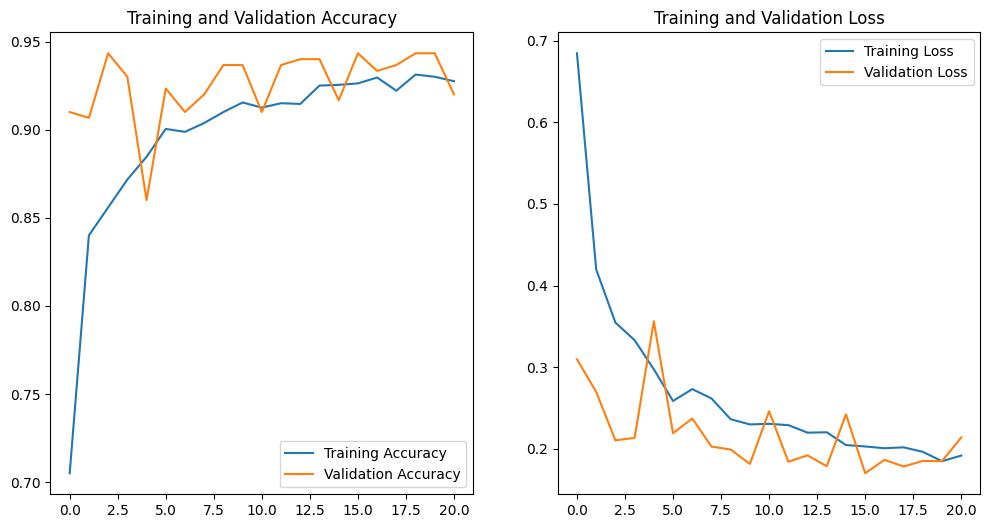

Test Loss: 0.1685705929994583
Test Accuracy: 0.9466666579246521


In [ ]:
# prompt: buatkan evaluasi model dan ploting akurasi dan loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Print the evaluation results
print("Test Loss:", Evaluation[0])
print("Test Accuracy:", Evaluation[1])


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step
Confusion Matrix:
[[35 34 31]
 [26 40 34]
 [29 36 35]]


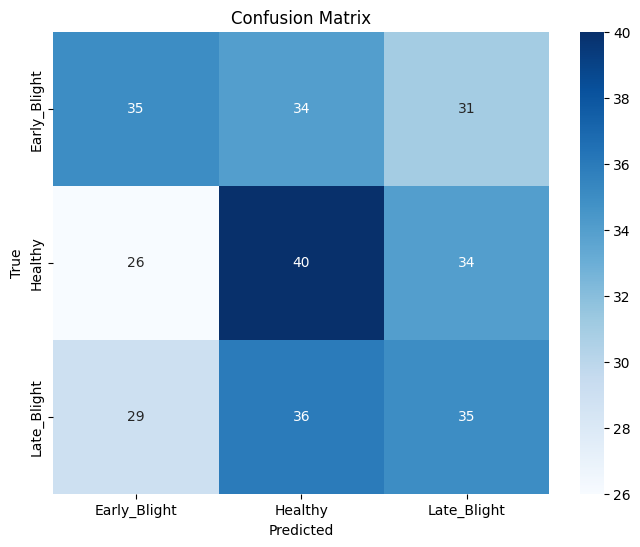

In [ ]:
# prompt: Confusion matrixnya

from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels for the test set
Y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(Y_true, y_pred)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

# You can also visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:


from sklearn.metrics import classification_report

# Get predictions for the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels for the test set
Y_true = test_generator.classes

# Generate a classification report
report = classification_report(Y_true, y_pred, target_names=list(test_generator.class_indices.keys()))

# Print the report
print(report)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
              precision    recall  f1-score   support

Early_Blight       0.30      0.27      0.28       100
     Healthy       0.31      0.34      0.32       100
 Late_Blight       0.30      0.30      0.30       100

    accuracy                           0.30       300
   macro avg       0.30      0.30      0.30       300
weighted avg       0.30      0.30      0.30       300



In [ ]:
# prompt: download modelnya

from google.colab import files

# Simpan model ke file
model.save('my_modelpp_mnet64.h5')

# Download file model
files.download('my_modelpp_mnet64.h5')
